In [2]:
import abacus_cosmos.Halos as ach
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import glob
from collections import Counter
%matplotlib inline

In [6]:
halo_path = "/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_17_FoF_halos_z0.100/"
halo_data = Table(ach.read_halos_FoF(halo_path))

In [8]:
print(len(halo_data))
halo_data[:5]

5924696


id,subsamp_start,subsamp_len,N,subhalo_N [4],pos [3],vel [3],sigma_v [3],r25,r50,r75,r90,vcirc_max,rvcirc_max,subhalo_pos [3],subhalo_vel [3],subhalo_sigma_v [3],subhalo_r25,subhalo_r50,subhalo_r75,subhalo_r90,subhalo_vcirc_max,subhalo_rvcirc_max
int64,uint64,uint32,uint32,uint32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
33242377525485,0,8632,86457,66786 .. 191,-253.09807 .. 294.97177,-244.67203 .. 90.640274,1455.3213 .. 865.20685,0.4466687,0.7742227,1.1946546,1.5634724,1697.4342,0.79902476,-253.10484 .. 294.91763,-221.34332 .. 105.39277,1455.4824 .. 865.3648,0.44472104,0.7717564,1.1946508,1.5654006,1700.9688,0.8557095
33242377525486,8632,8235,82541,53699 .. 697,-287.02658 .. -325.12607,202.39725 .. -117.29483,1168.337 .. 838.8079,0.49692518,0.90991926,1.340447,1.7939327,1550.3385,1.1095039,-287.0245 .. -325.0457,155.15703 .. -165.41293,1168.8907 .. 838.80804,0.45611867,0.8847868,1.3484306,1.8258499,1556.6445,1.002355
33242377525487,16867,6434,64013,46118 .. 246,-309.99973 .. -345.7318,99.962234 .. 125.551414,1118.0905 .. 723.04114,0.5954987,0.90822995,1.2278804,1.6819797,1420.2601,1.1961561,-309.87143 .. -345.63333,36.32825 .. 68.69389,1119.7126 .. 723.20776,0.57572097,0.879179,1.2404628,1.6827838,1415.2413,1.1444172
33242377525488,23301,5950,61268,44495 .. 105,-273.21002 .. 178.35641,-14.066784 .. -109.05763,1065.5233 .. 702.38684,0.40968856,0.7297003,1.1876155,1.6740216,1471.509,0.72254,-273.2574 .. 178.35477,27.928698 .. -111.21466,1066.0818 .. 702.5438,0.4054074,0.72185564,1.188385,1.669108,1479.2697,0.7206573
33242377525489,29251,4410,44118,35468 .. 68,-209.48268 .. -52.159897,286.80127 .. -300.69635,1010.9862 .. 691.3526,0.41313985,0.6973759,1.0187902,1.2836082,1298.9677,0.86523646,-209.47574 .. -52.14913,292.5222 .. -302.72525,1011.0349 .. 691.36426,0.4169215,0.69554836,1.016148,1.28225,1301.693,0.863017


(-395.99531647785875, 395.9876260481712, -395.9569453269616, 395.9637202293053)

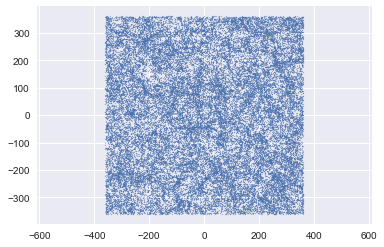

In [19]:
r = np.random.random(len(halo_data))
ii_r = (r<0.1) & (halo_data['pos'][:,2]>300) 
plt.scatter(halo_data['pos'][ii_r,0], halo_data['pos'][ii_r,1], s=1, alpha=0.4)
plt.axis('equal')